In [1]:
### imports
#import cv2
import json
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from nd2reader import ND2Reader
from sklearn.model_selection import train_test_split
from skimage.morphology import remove_small_objects
from csbdeep.utils import Path, normalize
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
import shutil 
from tqdm import tqdm
from tensorflow.keras.utils import Sequence

2025-03-11 09:38:59.773818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741682339.787995 1932004 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741682339.792252 1932004 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 09:38:59.808647: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Variables
### Variables
IMG_DIR = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs'
APO_DIR = '/mnt/imaging.data/PertzLab/apoDetection/ApoptosisAnnotation'
#DATA_SUBDIRS = ['2021-07-02']
#EXP_INFO_PATH = '/mnt/imaging.data/PertzLab/apoDetection/List of the experiments.csv'



COMPARE_2D_VERS = True
# Second model only necessary if COMPARE_2D_VERS=False
#MODEL2 = 

SAVE_MASKS = True
#SAVE_DATA_DIR = f'../masks/{MODEL1}'
H2B_MASK = 'standard_mask_c1_nuc.npz'
ERK_MASK ='erk_mask_c3_erk.npz'

LOAD_MASKS = True

USE_GPU = True

MIN_NUC_SIZE = 200
MASK_DIR = '../data/apo_masks'
CSV_DIR = '../data/apo_match_csv'
DF_DIR = '../data/summary_dfs'

## Plotting
#PLOTS_DIR = f'./output-plots/{MODEL1}'
#FRAME_SHOW = 15
#FOV_CROP_Y = slice(384, 684)  # [px]
#FOV_CROP_X = slice(128, 428)  # [px]

In [25]:
import os
import numpy as np
from nd2reader import ND2Reader
import tifffile as tiff
import logging

def load_image_stack(path):
    """
    Load an image stack from a file based on its extension.
    
    Uses tifffile for TIFF files and ND2Reader for ND2 files.
    """
    if path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        return tiff.imread(path)
    elif path.endswith('.nd2'):
        # Load ND2 file using ND2Reader and convert it to a numpy array
        with ND2Reader(path) as nd2:
            return np.array(nd2)
    else:
        raise ValueError(f"Unsupported file format for file: {path}")

def get_image_paths(directory):
    """
    Returns a list of absolute paths of all TIFF and ND2 files in a directory.
    """
    valid_extensions = ('.tif', '.tiff', '.nd2')
    paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(valid_extensions)
    ]
    return sorted(paths)

# Set up logging
#logging.basicConfig(
#    level=logging.INFO,
#    format='%(asctime)s [%(levelname)s] %(message)s',
#    filename='app.log',
#    filemode='a'
#)

# Collect image paths in IMG_DIR
image_paths = []
image_paths = get_image_paths(os.path.join(IMG_DIR))

### TODO remove :2 here, was only for testing
image_paths = np.array(image_paths).flatten()[:5]
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]

#print(image_paths)
#print(filenames)
axis_norm = (0,1)

# Set up GT_mask prediction with stardist
if USE_GPU:
    import gputools
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)

model = StarDist2D.from_pretrained("2D_versatile_fluo")    # Load standard model to create GT


# Create directories for saving if they do not exist
if not os.path.exists(CSV_DIR):
        os.makedirs(CSV_DIR)  
if not os.path.exists(MASK_DIR):
            os.makedirs(MASK_DIR)
if not os.path.exists(DF_DIR):
            os.makedirs(DF_DIR)

# Initialize list to collect distances between stardist and manual annotations
dist_paolo_stardist = []

# Loop over all files in target directory
for path, filename in zip(image_paths, filenames):
    # Load and normalize image stack
    h2b_imgs = load_image_stack(path) #[::step_size,:,:]
    h2b_imgs_normal = np.asarray([normalize(img,1,99.8,axis=axis_norm) for img in h2b_imgs])

    # Predict labels with pretrained stardist model
    gt = []    #--> lables
    details = []    # centroids and more
    for x in tqdm(h2b_imgs_normal):
        labels, det = model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
        gt.append(labels)
        details.append(det)
    gt = np.asarray(gt)

         
    # Remove small objects and create DF with segmentation info (object_id, t, x, y)
    gt_filtered = np.zeros_like(gt, dtype=np.uint16)
    num_frames = gt.shape[0]
    df_list = []
    for frame in range(num_frames):
        gt_filtered[frame] = remove_small_objects(
            gt[frame],
            min_size = MIN_NUC_SIZE
        )

        # Create DF after removing small objects
        unique_ids = np.unique(gt_filtered[frame])
        unique_ids = unique_ids[unique_ids > 0]
        x = []
        y = []
        timepoint = np.full_like(unique_ids, frame)

        current_details = details[frame]['points']    # --> centroids
        for obj_id in unique_ids:
            position = current_details[obj_id - 1]    # -1 because obj have 1 indexing, centroids start from 0
            x.append(position[1])
            y.append(position[0])

        d = {
            'obj_id': unique_ids,
            't': timepoint,
            'x': x,
            'y': y
        }
        current_df = pd.DataFrame(d)
        df_list.append(current_df)

    # Concatenate DFs for each t so we get one DF per file
    summary_df = pd.concat(df_list, ignore_index = True)
    

    # Read CSV with manual apoptosis annotations 
    apo_file = os.path.join(APO_DIR, f'{filename}.csv')
    apo_annotations = pd.read_csv(apo_file, header=None, names=['filename', 'x', 'y', 't'])

    # Match handmade annotations with stardist detections
    corresponding_objects = []
    strdst_x = []
    strdst_y = []
    for _, row in apo_annotations.iterrows():
        t, x, y = int(row['t']), int(row['x']), int(row['y'])
        # Perfect match
        if gt_filtered[t, y, x] != 0:
            corresponding_objects.append(gt_filtered[t, y, x])
        # Also search previous and coming frames if position is background at time t
        else:
            t_start = max(0, t-3)
            t_end = min(t+3, gt_filtered.shape[0])
            previous_frames = gt_filtered[t_start:t_end, y, x]
            if previous_frames.size > 0:
                counts = np.bincount(previous_frames)
                match_id = np.argmax(counts)
            else:
                match_id = 0            
            corresponding_objects.append(match_id)
        # Extract centroid of best matching object
        centroids = details[t]['points']
        match_centroid = centroids[corresponding_objects[-1]-1] if corresponding_objects[-1] > 0 else (9999, 9999)
        strdst_x.append(match_centroid[1])
        strdst_y.append(match_centroid[0])
        # Euclidean distance, used for plotting and validation
        distance_to_paolo = np.sqrt(((match_centroid[1]- row['x'])**2 + (match_centroid[0] - row['y'])**2))
        dist_paolo_stardist.append(distance_to_paolo)

    # Add object ID and centroids to apo annotation dataframe    
    apo_annotations['matching_object'] = corresponding_objects
    apo_annotations['strdst_x'] = strdst_x
    apo_annotations['strdst_y'] = strdst_y

    # Save again as CSV with added stardist centroids      
    apo_annotations.to_csv(os.path.join(CSV_DIR, f'{filename}.csv'), index=False)

    # Save summary df as CSV
    summary_df.to_csv(os.path.join(DF_DIR, f'{filename}_pd_df.csv'), index=False)

    
    # Save labels
    if SAVE_MASKS:
        mask_path = os.path.join(MASK_DIR, f'{filename}.npz')
        np.savez_compressed(mask_path, gt=gt_filtered)

['/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp01_Site01.tif'
 '/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp01_Site02.tif'
 '/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp01_Site03.tif'
 '/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp01_Site04.tif'
 '/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp01_Site05.tif']
['Exp01_Site01', 'Exp01_Site02', 'Exp01_Site03', 'Exp01_Site04', 'Exp01_Site05']
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [12:54<00:00,  1.86it/s]


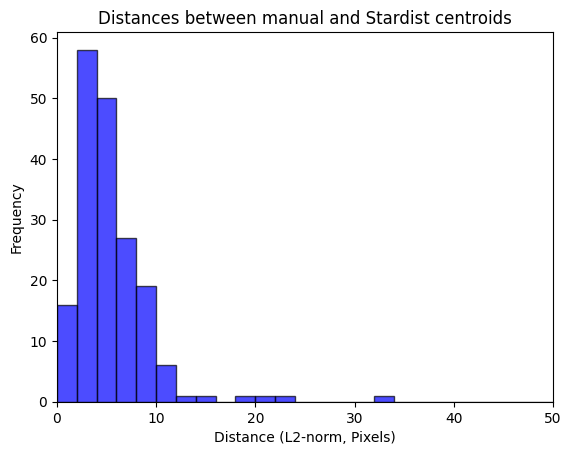

In [41]:
# Create histogram
plt.hist(dist_paolo_stardist, bins=25, range=(0, 50), color='blue', edgecolor='black', alpha=0.7)
plt.xlim(0, 50)


# Labels and title
plt.xlabel('Distance (L2-norm, Pixels)')
plt.ylabel('Frequency')
plt.title('Distances between manual and Stardist centroids')

# Show plot
plt.show()

In [14]:
print(details[1].keys())

dict_keys(['coord', 'points', 'prob'])


In [16]:
print(gt_filtered.shape)

(1441, 1024, 1024)


In [25]:
print(np.unique(gt_filtered[5, :, :]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [22]:
h2b_imgs.shape

(1441, 1024, 1024)